In [9]:
%pip install basicsr facexlib realesrgan gfpgan

In [10]:
!wget https://github.com/TencentARC/GFPGAN/releases/download/v1.3.0/GFPGANv1.3.pth -P models/
!wget https://github.com/xinntao/Real-ESRGAN/releases/download/v0.1.0/RealESRGAN_x4plus.pth -P models/

--2025-10-07 19:17:34--  https://github.com/TencentARC/GFPGAN/releases/download/v1.3.0/GFPGANv1.3.pth
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/349321229/e9847322-b8b1-4ec2-9620-5146eb8a9e4b?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-10-07T19%3A57%3A57Z&rscd=attachment%3B+filename%3DGFPGANv1.3.pth&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-10-07T18%3A57%3A37Z&ske=2025-10-07T19%3A57%3A57Z&sks=b&skv=2018-11-09&sig=lE%2Bkqot9h1zWa0ncjEwOw78ZrRPdBhQsCnfB8PYdZ3c%3D&jwt=eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9.eyJpc3MiOiJnaXRodWIuY29tIiwiYXVkIjoicmVsZWFzZS1hc3NldHMuZ2l0aHVidXNlcmNvbnRlbnQuY29tIiwia2V5Ijoia2V5MSIsImV4cCI6MTc1OTg2ODI1NSwibmJmIjoxNzU5ODY0NjU1LCJwYXRoIjoicmVsZWFzZWFzc2V0cHJvZHVjdGlvbi5i

In [16]:
import cv2
import torch
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from gfpgan import GFPGANer
from realesrgan import RealESRGANer
from basicsr.archs.rrdbnet_arch import RRDBNet
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

In [12]:
esrgan_arch = RRDBNet(
    num_in_ch=3,
    num_out_ch=3,
    num_feat=64,
    num_block=23,
    num_grow_ch=32,
    scale=4
)

bg_upsampler = RealESRGANer(
    scale=4,
    model=esrgan_arch,
    model_path="models/RealESRGAN_x4plus.pth",
    device=torch.device("cuda"),
    half=True
)

restorer = GFPGANer(
      model_path="models/GFPGANv1.3.pth",
      upscale=4,
      arch="clean",
      channel_multiplier=2,
      bg_upsampler=bg_upsampler,
      device=torch.device("cuda")
    )

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [25]:
def degrade_image(source_path, output_path, scale=0.25):
    img = cv2.imread(str(source_path))
    img_downsampled = cv2.resize(
        src=img,
        dsize=None,
        fx=scale,
        fy=scale,
        interpolation=cv2.INTER_AREA
    )
    print(img_downsampled.shape)
    cv2.imwrite(str(output_path), img_downsampled)

In [34]:
def process_and_evaluate(degraded_path, ground_truth_path, output_path):
    degraded_img = cv2.imread(str(degraded_path), cv2.IMREAD_COLOR)
    gt_img = cv2.imread(str(ground_truth_path), cv2.IMREAD_COLOR)

    degraded_img_rgb = cv2.cvtColor(degraded_img, cv2.COLOR_BGR2RGB)

    _, _, restored_img_rgb = restorer.enhance(
        degraded_img_rgb,
        has_aligned=False,
        only_center_face=False,
        paste_back=True
    )

    restored_img_bgr = cv2.cvtColor(restored_img_rgb, cv2.COLOR_RGB2BGR)
    cv2.imwrite(str(output_path), restored_img_bgr)

    gt_for_baseline = cv2.resize(gt_img, (degraded_img.shape[1], degraded_img.shape[0]), interpolation=cv2.INTER_AREA)
    gt_for_restored = cv2.resize(cv2.cvtColor(gt_img, cv2.COLOR_BGR2RGB), (restored_img_rgb.shape[1], restored_img_rgb.shape[0]), interpolation=cv2.INTER_AREA)

    baseline_psnr = psnr(gt_for_baseline, degraded_img, data_range=255)
    baseline_ssim = ssim(gt_for_baseline, degraded_img, channel_axis=-1, data_range=255)

    restored_psnr = psnr(gt_for_restored, restored_img_rgb, data_range=255)
    restored_ssim = ssim(gt_for_restored, restored_img_rgb, channel_axis=-1, data_range=255)

    return {
        "filename": ground_truth_path.name,
        "baseline_psnr": baseline_psnr,
        "restored_psnr": restored_psnr,
        "baseline_ssim": baseline_ssim,
        "restored_ssim": restored_ssim,
    }

In [35]:
ground_truth_dir = Path("ground_truth")
degraded_dir = Path("degraded_inputs")
restored_dir = Path("restored_outputs")

degraded_dir.mkdir(exist_ok=True)
restored_dir.mkdir(exist_ok=True)

print("--- Degrading Images ---")
for file_path in ground_truth_dir.glob("*.*"):
    if file_path.suffix.lower() in [".png", ".jpg", ".jpeg"]:
        degraded_path = degraded_dir / file_path.name
        degrade_image(file_path, degraded_path)

print("\n--- Processing Images and Calculating Metrics ---")
results = []
for file_path in ground_truth_dir.glob("*.*"):
    if file_path.suffix.lower() in [".png", ".jpg", ".jpeg"]:
        degraded_path = degraded_dir / file_path.name
        restored_path = restored_dir / file_path.name

        print(f"Processing {file_path.name}...")
        metrics = process_and_evaluate(degraded_path, file_path, restored_path)
        results.append(metrics)

print("\n--- Results Summary ---")
df = pd.DataFrame(results)
df.round(2)

--- Degrading Images ---
(480, 320, 3)
(180, 320, 3)
(320, 480, 3)
(180, 320, 3)

--- Processing Images and Calculating Metrics ---
Processing man-7112557_1920.jpg...
Processing import_62de2b69a72165.68343753_large-2458191007.jpg...
Processing merry-christmas-2425121_1920.jpg...
Processing import_62df810bb5e279.86816168_large-2712396071.jpg...

--- Results Summary ---


filename  baseline_psnr  \
0                               man-7112557_1920.jpg          40.41   
1  import_62de2b69a72165.68343753_large-245819100...          42.81   
2                   merry-christmas-2425121_1920.jpg          38.65   
3  import_62df810bb5e279.86816168_large-271239607...          43.69   

   restored_psnr  baseline_ssim  restored_ssim  
0          26.66           0.98           0.67  
1          34.69           0.98           0.95  
2          26.48           0.98           0.74  
3          34.30           0.99           0.94

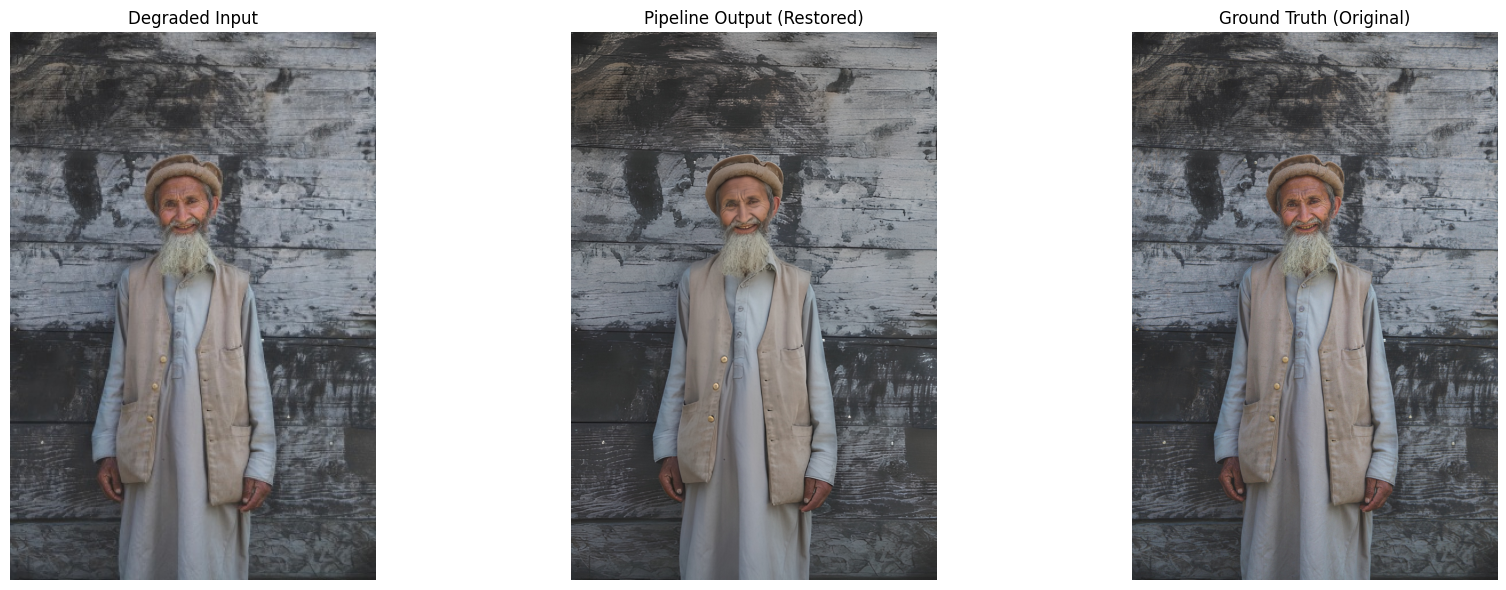

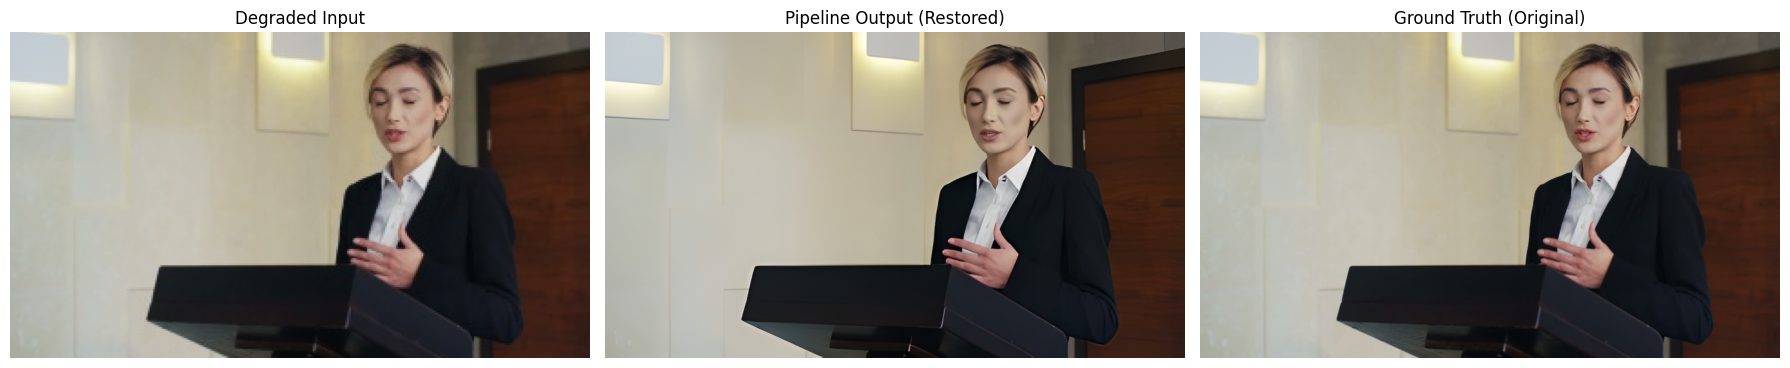

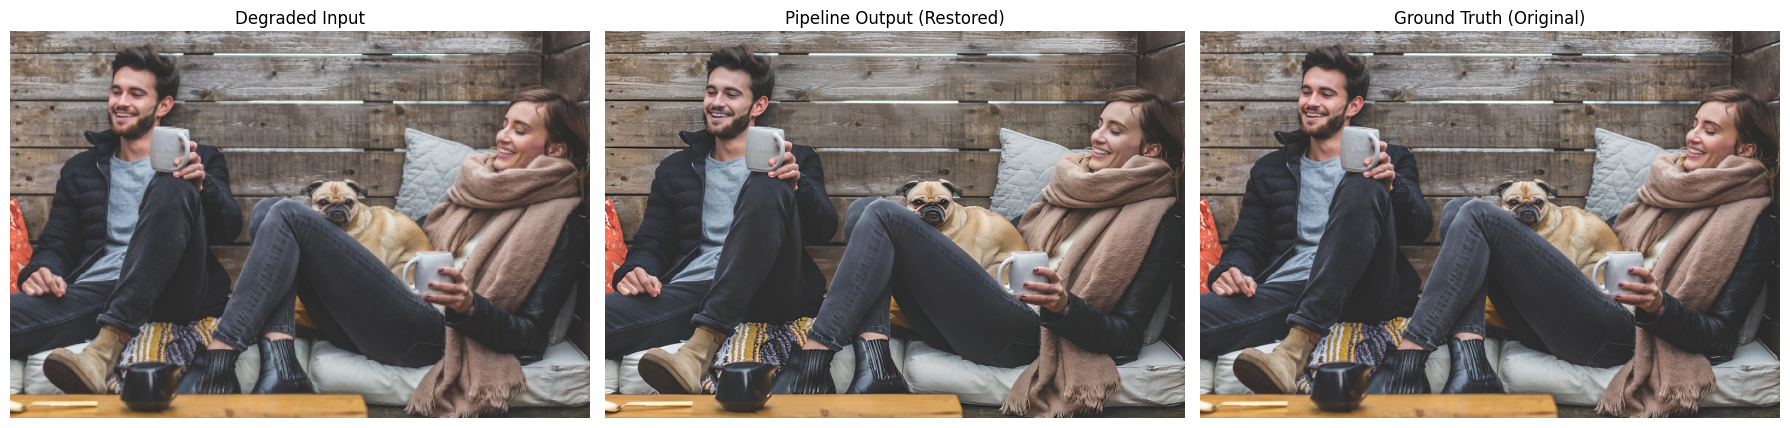

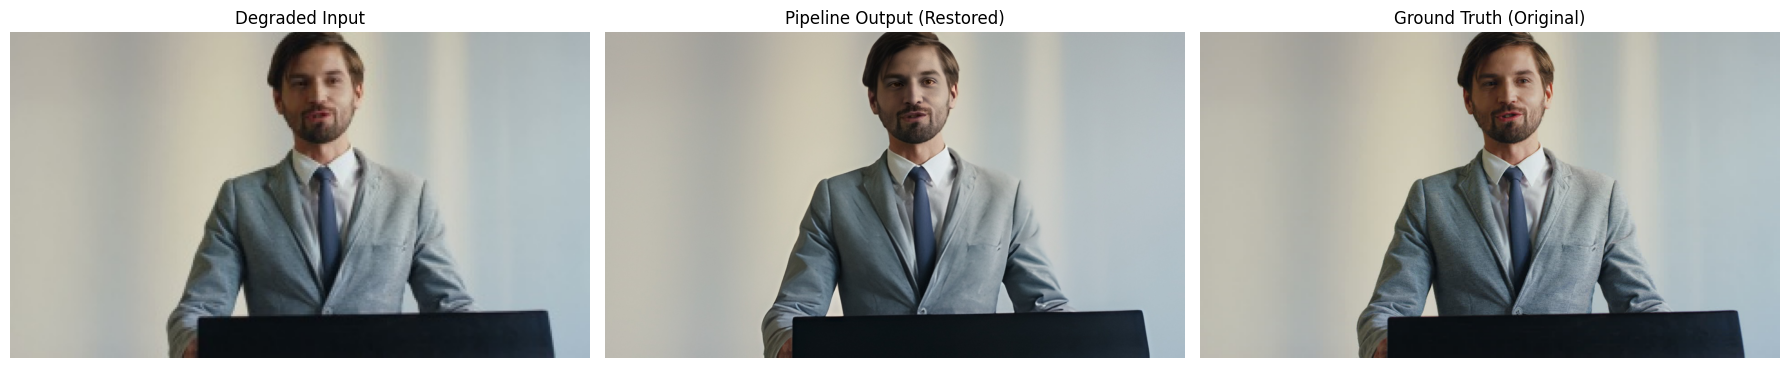

In [36]:
degraded_dir = Path("degraded_inputs")
restored_dir = Path("restored_outputs")
ground_truth_dir = Path("ground_truth")
comparison_dir = Path("comparisons")
comparison_dir.mkdir(exist_ok=True)

for gt_path in ground_truth_dir.glob("*.*"):
    if gt_path.suffix.lower() not in [".png", ".jpg", ".jpeg"]:
        continue

    filename = gt_path.name
    degraded_path = degraded_dir / filename
    restored_path = restored_dir / filename


    degraded_img = cv2.imread(str(degraded_path))
    restored_img = cv2.imread(str(restored_path))
    gt_img = cv2.imread(str(gt_path))

    degraded_img_rgb = cv2.cvtColor(degraded_img, cv2.COLOR_BGR2RGB)
    restored_img_rgb = cv2.cvtColor(restored_img, cv2.COLOR_BGR2RGB)
    gt_img_rgb = cv2.cvtColor(gt_img, cv2.COLOR_BGR2RGB)

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    axes[0].imshow(degraded_img_rgb)
    axes[0].set_title("Degraded Input")
    axes[0].axis("off")

    axes[1].imshow(restored_img_rgb)
    axes[1].set_title("Pipeline Output (Restored)")
    axes[1].axis("off")

    axes[2].imshow(gt_img_rgb)
    axes[2].set_title("Ground Truth (Original)")
    axes[2].axis("off")

    plt.tight_layout()

    save_path = comparison_dir / f"comparison_{filename}"
    plt.savefig(save_path, dpi=200, bbox_inches="tight")

    plt.show()